In [700]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from decimal import Decimal 
import datetime as dt


In [701]:
df = pd.read_csv('OnlineRetail.csv')
df

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,0,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
1,1,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
2,2,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
3,3,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
4,4,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom
...,...,...,...,...,...,...,...,...,...
200333,200333,581587,22726,ALARM CLOCK BAKELIKE GREEN,4,2011-12-09 12:50:00,3.75,12680.0,France
200334,200334,581587,22730,ALARM CLOCK BAKELIKE IVORY,4,2011-12-09 12:50:00,3.75,12680.0,France
200335,200335,581587,23256,CHILDRENS CUTLERY SPACEBOY,4,2011-12-09 12:50:00,4.15,12680.0,France
200336,200336,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France


In [702]:
df.drop('Unnamed: 0', inplace=True, axis=1)
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
1,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
2,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
3,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
4,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom
...,...,...,...,...,...,...,...,...
200333,581587,22726,ALARM CLOCK BAKELIKE GREEN,4,2011-12-09 12:50:00,3.75,12680.0,France
200334,581587,22730,ALARM CLOCK BAKELIKE IVORY,4,2011-12-09 12:50:00,3.75,12680.0,France
200335,581587,23256,CHILDRENS CUTLERY SPACEBOY,4,2011-12-09 12:50:00,4.15,12680.0,France
200336,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France


In [703]:
# Verify the existence of NaN values
df.isna().sum()

InvoiceNo          0
StockCode          0
Description      554
Quantity           0
InvoiceDate        0
UnitPrice          0
CustomerID     49962
Country            0
dtype: int64

In [704]:
df.dropna(inplace=True)

In [705]:
# Dropping rows with negative quantity.
df = df[~df['Quantity'] < 0]

In [706]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147069 entries, 0 to 200337
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    147069 non-null  object 
 1   StockCode    147069 non-null  object 
 2   Description  147069 non-null  object 
 3   Quantity     147069 non-null  int64  
 4   InvoiceDate  147069 non-null  object 
 5   UnitPrice    147069 non-null  float64
 6   CustomerID   147069 non-null  float64
 7   Country      147069 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 10.1+ MB


In [707]:
# Setting data types 
df['InvoiceNo'] = df['InvoiceNo'].astype('str')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['CustomerID'] = df['CustomerID'].astype('str')
df['Description'] = df['Description'].astype('str')
df['StockCode'] = df['StockCode'].astype('str')
df['Country'] = df['Country'].astype('str')
df['UnitPrice'] = df['UnitPrice'].apply(Decimal)

In [708]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147069 entries, 0 to 200337
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    147069 non-null  object        
 1   StockCode    147069 non-null  object        
 2   Description  147069 non-null  object        
 3   Quantity     147069 non-null  int64         
 4   InvoiceDate  147069 non-null  datetime64[ns]
 5   UnitPrice    147069 non-null  object        
 6   CustomerID   147069 non-null  object        
 7   Country      147069 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 10.1+ MB


In [709]:
# Creating the monetary value of the transactions (quantity * price)
df['Monetary'] = df['Quantity'] * df['UnitPrice']
df['Monetary'] = df['Monetary'].apply(Decimal)
df['Monetary']

0         20.34000000000000074606987255
1                                 25.50
2         11.10000000000000053290705182
3         11.10000000000000053290705182
4         54.07999999999999829469743418
                      ...              
200333                            15.00
200334                            15.00
200335    16.60000000000000142108547152
200336    16.60000000000000142108547152
200337    14.85000000000000053290705182
Name: Monetary, Length: 147069, dtype: object

__Computing the summary data__.

In [710]:
# Computing the summary data (Recency, Frequency, monetary and tenure)
df_rfmt = summary_data_from_transaction_data(transactions = df, 
                                         customer_id_col = 'CustomerID', 
                                         datetime_col = 'InvoiceDate', 
                                         monetary_value_col = 'Monetary')
df_rfmt.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12347.0,6.0,365.0,367.0,202.878333
12348.0,2.0,283.0,358.0,136.760000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000
12352.0,6.0,260.0,296.0,108.130000


__Splitting the data__

In [719]:
# Size of the data 
# we have 373 days of data.
# We will use 200 days as calibration data and the rest as observation data 
# to evaluate the performance of the model.
diff_time = df['InvoiceDate'].max() - df['InvoiceDate'].min() 
diff_time

Timedelta('373 days 04:24:00')

In [720]:
# Getting the ending date of the calibration period. 
end_date_cal = df['InvoiceDate'].min() + dt.timedelta(days=200)
end_date_obs = end_date_cal + (diff_time - dt.timedelta(days=200))
end_date_obs

Timestamp('2011-12-09 12:50:00')

In [721]:
# Verify if the calculations are correct. 
df['InvoiceDate'].max() == end_date_obs

True

In [723]:
df_rfmt_cal = calibration_and_holdout_data(transactions=df, 
                                          customer_id_col="CustomerID",
                                          datetime_col = "InvoiceDate", 
                                          calibration_period_end=end_date_cal,
                                          observation_period_end= end_date_obs)
df_rfmt_cal

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
12347.0,3.0,184.0,194.0,3.0,173.0
12348.0,1.0,40.0,185.0,1.0,173.0
12350.0,0.0,0.0,137.0,0.0,173.0
12352.0,3.0,34.0,123.0,3.0,173.0
12353.0,0.0,0.0,31.0,0.0,173.0
...,...,...,...,...,...
18270.0,0.0,0.0,93.0,1.0,173.0
18272.0,1.0,21.0,73.0,4.0,173.0
18280.0,0.0,0.0,104.0,0.0,173.0


__Tuning the model__.

In [724]:
l2_coefs = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
l2_list = []
rmse_list = []
for coef in l2_coefs :
    # Fitting the model using the calibration dataset.
    model = BetaGeoFitter(penalizer_coef=coef)
    model.fit(df_rfmt_cal['frequency_cal'], 
        df_rfmt_cal['recency_cal'], 
        df_rfmt_cal['T_cal'])
    # Predicting the frequency for the holdout period for all customers. 
    pred_freq = pd.DataFrame(model.predict(df_rfmt_cal['duration_holdout'], 
                                 df_rfmt_cal['frequency_cal'], df_rfmt_cal['recency_cal'], df_rfmt_cal['T_cal']), columns=['pred_frequency']).reset_index()
    # Merging the two dataframes and dropping NaN values. 
    new_df = df_rfmt_cal.reset_index().merge(pred_freq, on='CustomerID').dropna()

    # Computing the rmse score 
    rmse_score = np.sqrt(mean_squared_error(new_df['frequency_holdout'],new_df['pred_frequency']))
    l2_list.append(coef)
    rmse_list.append(rmse_score)

c:\users\afify\appdata\local\programs\python\python38\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\users\afify\appdata\local\programs\python\python38\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\users\afify\appdata\local\programs\python\python38\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\users\afify\appdata\local\programs\python\python38\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\users\afify\appdata\local\programs\python\python38\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)

In [725]:
# Getting the results 
pd.DataFrame(np.array(rmse_list), columns=['rmse_score']).merge(pd.DataFrame(np.array(l2_list), columns=['L2 coefs']), right_index=True, left_index=True)

,rmse_score,L2 coefs
0,2.310498,0.3
1,2.295194,0.4
2,2.289356,0.5
3,2.282449,0.6
4,2.279248,0.7
5,2.278271,0.8
6,2.283926,0.9
7,2.282128,1.0


In [726]:
# Fitting the model using the calibration dataset.
model = BetaGeoFitter(penalizer_coef=0.80)
model.fit(df_rfmt_cal['frequency_cal'], 
        df_rfmt_cal['recency_cal'], 
        df_rfmt_cal['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 2774 subjects, a: 0.00, alpha: 23.63, b: 0.00, r: 0.28>

c:\users\afify\appdata\local\programs\python\python38\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


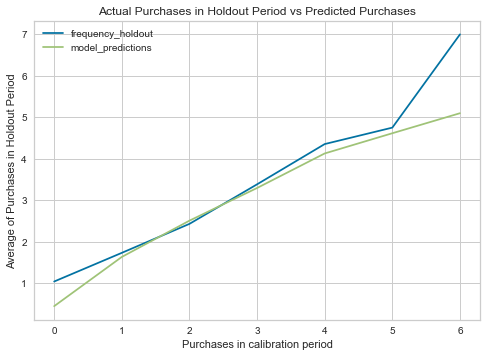

In [727]:
# Evaluating the performance of the model.
plot_calibration_purchases_vs_holdout_purchases(model, df_rfmt_cal)
plt.savefig('calib_hold.png')

In [728]:
# Predicting the number of purchases in the next 180 days for the first customer.

# Getting the customer data
customer_1 = df_rfmt.iloc[0:1]

# Predicting 
n_trans = model.predict(180, 
            customer_1['frequency'], 
            customer_1['recency'], 
            customer_1['T'])
n_trans

CustomerID
12347.0    2.895862
dtype: float64

In [729]:
# Predicting the number of purchases in the next 180 days for all customers.
df_rfmt['predicted_purchases'] = model.conditional_expected_number_of_purchases_up_to_time(180, 
                                                                                      df_rfmt['frequency'], 
                                                                                      df_rfmt['recency'], 
                                                                                      df_rfmt['T'])


c:\users\afify\appdata\local\programs\python\python38\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [730]:
df_rfmt.dropna(inplace=True)

In [731]:
df_rfmt

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
12347.0,6.0,365.0,367.0,202.878333,2.895862
12348.0,2.0,283.0,358.0,136.760000,1.077508
12350.0,0.0,0.0,310.0,0.000000,0.153281
12352.0,6.0,260.0,296.0,108.130000,3.539127
12353.0,0.0,0.0,204.0,0.000000,0.224568
...,...,...,...,...,...
18278.0,0.0,0.0,73.0,0.000000,0.528455
18280.0,0.0,0.0,277.0,0.000000,0.170089
18282.0,1.0,119.0,126.0,17.700000,1.536141


__Predicting Customer lifetime value__

In [732]:
# Getting rid of negative values.
df_rfmt = df_rfmt[df_rfmt['monetary_value']>0]

In [733]:
# Fitting the GammaGamma model 

gg_model = GammaGammaFitter()
gg_model.fit(df_rfmt['frequency'], df_rfmt['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 2669 subjects, p: 2.22, q: 3.36, v: 175.20>

In [734]:
df_rfmt['pred_monetary'] = ggf.conditional_expected_average_profit(
        df_rfmt['frequency'],
        df_rfmt['monetary_value'])

In [735]:
df_rfmt

,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary
CustomerID,,,,,,
12347.0,6.0,365.0,367.0,202.878333,2.895862,197.189469
12348.0,2.0,283.0,358.0,136.760000,1.077508,146.564367
12352.0,6.0,260.0,296.0,108.130000,3.539127,116.684671
12356.0,1.0,80.0,325.0,229.900000,0.646150,196.499384
12358.0,1.0,149.0,150.0,302.800000,1.324216,231.860840
...,...,...,...,...,...,...
18270.0,1.0,228.0,266.0,97.800000,0.793018,132.421903
18272.0,5.0,244.0,246.0,215.242000,3.527839,206.449363
18282.0,1.0,119.0,126.0,17.700000,1.536141,93.567958


In [736]:
# Predicting the CLV.
df_rfmt['CLV'] = gg_model.customer_lifetime_value(
    model,
    df_rfmt['frequency'],
    df_rfmt['recency'],
    df_rfmt['T'],
    df_rfmt['monetary_value'],
    time = 6,# In months 
    )
    

In [737]:
df_rfmt

,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary,CLV
CustomerID,,,,,,,
12347.0,6.0,365.0,367.0,202.878333,2.895862,197.189469,551.568608
12348.0,2.0,283.0,358.0,136.760000,1.077508,146.564367,152.541078
12352.0,6.0,260.0,296.0,108.130000,3.539127,116.684671,398.885094
12356.0,1.0,80.0,325.0,229.900000,0.646150,196.499384,122.639994
12358.0,1.0,149.0,150.0,302.800000,1.324216,231.860840,296.567975
...,...,...,...,...,...,...,...
18270.0,1.0,228.0,266.0,97.800000,0.793018,132.421903,101.433299
18272.0,5.0,244.0,246.0,215.242000,3.527839,206.449363,703.493618
18282.0,1.0,119.0,126.0,17.700000,1.536141,93.567958,138.834055


In [740]:
# Computing the probability of being alive.
df_rfmt['prob_alive'] = model.conditional_probability_alive(frequency=df_rfmt['frequency'],
                                                           recency=df_rfmt['recency'],
                                                           T=df_rfmt['T'])

In [741]:
df_rfmt

,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary,CLV,prob_alive
CustomerID,,,,,,,,
12347.0,6.0,365.0,367.0,202.878333,2.895862,197.189469,551.568608,1.000000
12348.0,2.0,283.0,358.0,136.760000,1.077508,146.564367,152.541078,0.999999
12352.0,6.0,260.0,296.0,108.130000,3.539127,116.684671,398.885094,1.000000
12356.0,1.0,80.0,325.0,229.900000,0.646150,196.499384,122.639994,0.974299
12358.0,1.0,149.0,150.0,302.800000,1.324216,231.860840,296.567975,0.994437
...,...,...,...,...,...,...,...,...
18270.0,1.0,228.0,266.0,97.800000,0.793018,132.421903,101.433299,0.993392
18272.0,5.0,244.0,246.0,215.242000,3.527839,206.449363,703.493618,1.000000
18282.0,1.0,119.0,126.0,17.700000,1.536141,93.567958,138.834055,0.994130


__Customers segmentation__

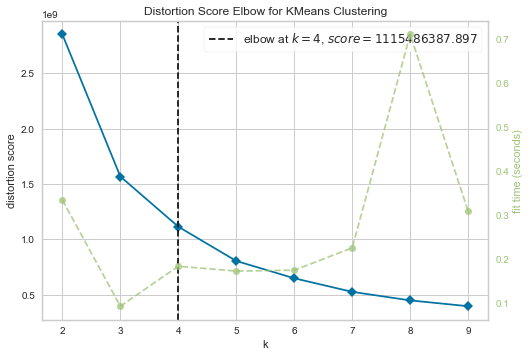

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [757]:
from yellowbrick.cluster import KElbowVisualizer


# Instantiate the clustering model and visualizer
km_model = KMeans()
visualizer = KElbowVisualizer(km_model, k=(2,10))

visualizer.fit(df_rfmt)  # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure


In [550]:
# Training the model with the optimal number of clusters according the elbow metho
km_model = KMeans(n_clusters=4)
km_model.fit(df_rfmt)

KMeans(n_clusters=4)

In [551]:
df_rfmt['cluster'] = km_model.labels_
df_rfmt

,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary,CLV,prob_alive,cluster
CustomerID,,,,,,,,,
12347.0,6.0,365.0,367.0,202.878333,2.895862,197.189469,551.568608,1.000000,0
12348.0,2.0,283.0,358.0,136.760000,1.077508,146.564367,152.541078,0.999999,0
12352.0,6.0,260.0,296.0,108.130000,3.539127,116.684671,398.885094,1.000000,0
12356.0,1.0,80.0,325.0,229.900000,0.646150,196.499384,122.639994,0.974299,0
12358.0,1.0,149.0,150.0,302.800000,1.324216,231.860840,296.567975,0.994437,0
...,...,...,...,...,...,...,...,...,...
18270.0,1.0,228.0,266.0,97.800000,0.793018,132.421903,101.433299,0.993392,0
18272.0,5.0,244.0,246.0,215.242000,3.527839,206.449363,703.493618,1.000000,0
18282.0,1.0,119.0,126.0,17.700000,1.536141,93.567958,138.834055,0.994130,0


In [692]:
# Grouping by clusters
df_clusters = df_rfmt.groupby(['cluster'])['CLV']\
                     .agg(['mean', "count"])\
                     .reset_index()

df_clusters.columns = ["cluster", "avg_CLV", "n_customers"]

df_clusters['perct_customers'] = (df_clusters['n_customers']/df_clusters['n_customers']\
                                  .sum())*100
df_clusters 

,cluster,avg_CLV,n_customers,perct_customers
0,0,395.086399,2612,97.864369
1,1,37242.654944,4,0.149869
2,2,4537.561030,46,1.723492
3,3,16019.649621,7,0.262271


In [569]:
# Let's name the clusters.
df_rfmt['customer_category'] = df_rfmt['cluster'].replace({3:"Gold", 1:"Diamond", 2:"Silver", 0:"Bronze"})

In [673]:
# Grouping by customer category
df_cat = pd.DataFrame(df_rfmt.groupby(['customer_category'])['CLV'].agg('mean')).reset_index()

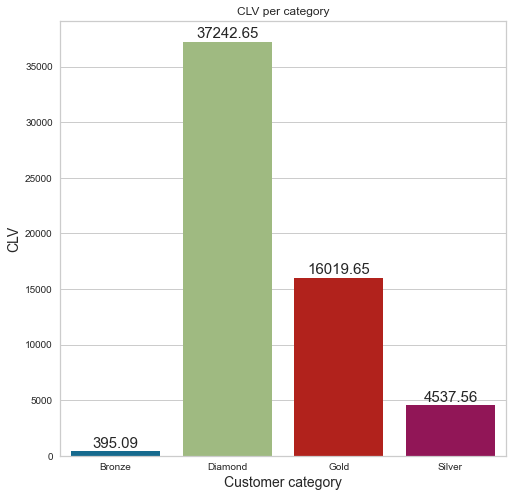

In [674]:
# Code source : https://www.geeksforgeeks.org/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/
# Defining the plot size
plt.figure(figsize=(8, 8))
 
# Defining the values for x-axis, y-axis
# and from which dataframe the values are to be picked
plots = sns.barplot(x="customer_category", y="CLV", data=df_cat)
 
# Iterating over the bars one-by-one
for bar in plots.patches:
   
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),textcoords='offset points')

plt.xlabel("Customer category", size=14)
 
# Setting the label for y-axis
plt.ylabel("CLV", size=14)
 
# Setting the title for the graph
plt.title("CLV per category")
 
# Finally showing the plot
plt.show()

In [679]:
# Computing the contribution of each category to the total CLV of the next six months
df_cat["contribution_to_CLV"] = df_cat['CLV']/df_cat['CLV'].sum()*100

,customer_category,CLV,contribution,contribution_to_CLV
0,Bronze,395.086399,0.678901,0.678901
1,Diamond,37242.654944,63.996367,63.996367
2,Gold,16019.649621,27.527559,27.527559
3,Silver,4537.561030,7.797173,7.797173


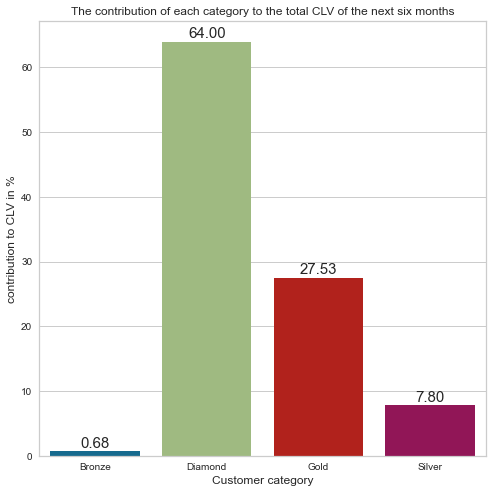

In [683]:
# Code source : https://www.geeksforgeeks.org/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/
# Defining the plot size
plt.figure(figsize=(8, 8))
 
# Defining the values for x-axis, y-axis
# and from which dataframe the values are to be picked
plots = sns.barplot(x="customer_category", y="contribution_to_CLV", data=df_cat)
 
# Iterating over the bars one-by-one
for bar in plots.patches:
   
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),textcoords='offset points')

plt.xlabel("Customer category", size=12)

# Setting the label for y-axis
plt.ylabel("contribution to CLV in %", size=12)
 
# Setting the title for the graph
plt.title("The contribution of each category to the total CLV of the next six months")
 
# Finally showing the plot
plt.show()

__Analyzing the frequency__

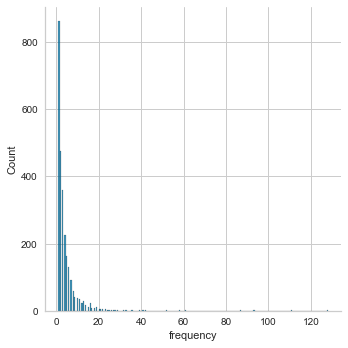

In [575]:
sns.displot(df_rfmt['frequency'])
plt.show()

In [608]:
df_freq = pd.DataFrame(df_rfmt.groupby(['customer_category'])['frequency'].mean().reset_index())

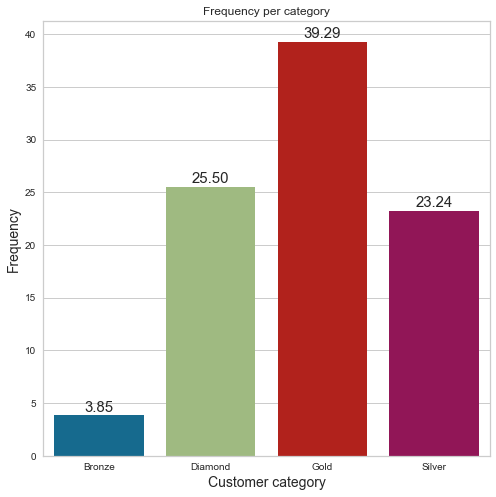

In [609]:
# Code source : https://www.geeksforgeeks.org/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/
# Defining the plot size
plt.figure(figsize=(8, 8))
 
# Defining the values for x-axis, y-axis
# and from which dataframe the values are to be picked
plots = sns.barplot(x="customer_category", y="frequency", data=df_freq)
 
# Iterating over the bars one-by-one
for bar in plots.patches:
   
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),textcoords='offset points')

plt.xlabel("Customer category", size=14)
 
# Setting the label for y-axis
plt.ylabel("Frequency", size=14)
 
# Setting the title for the graph
plt.title("Frequency per category")
 
# Finally showing the plot
plt.show()

Gold customers purchase more frequently from the company

In [576]:
df_rfmt['frequency'].describe()

count    2669.000000
mean        4.311353
std         6.598983
min         1.000000
25%         1.000000
50%         2.000000
75%         5.000000
max       128.000000
Name: frequency, dtype: float64

In [649]:
# Getting the percentage of customers with a frequency less than 10.

len(df_rfmt[df_rfmt['frequency'] < 10])/len(df_rfmt)

0.9037092544023979

In [612]:
# Getting the number of customers per category for those with a frequency greater than 10.

df_freq_1 = pd.DataFrame(df_rfmt[df_rfmt['frequency'] > 10]\
                        .groupby(['customer_category'])['customer_category']\
                        .agg('count'))

df_freq_1.columns = ['n_customers']

df_freq_1 = df_freq_1.reset_index()

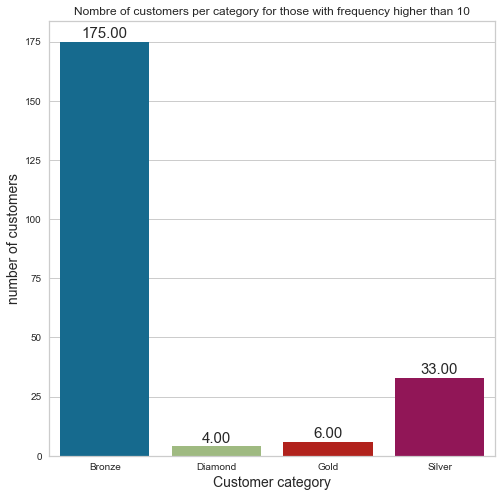

In [613]:
# Code source : https://www.geeksforgeeks.org/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/
# Defining the plot size
plt.figure(figsize=(8, 8))
 
# Defining the values for x-axis, y-axis
# and from which dataframe the values are to be picked
plots = sns.barplot(x="customer_category", y="n_customers", data=df_freq_1)
 
# Iterating over the bars one-by-one
for bar in plots.patches:
   
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),textcoords='offset points')

plt.xlabel("Customer category", size=14)
 
# Setting the label for y-axis
plt.ylabel("number of customers", size=14)

# Setting the title for the graph
plt.title("Nombre of customers per category for those with frequency higher than 10")
 
# Finally showing the plot
plt.show()

In [616]:
# Getting the number of customers per category for those with a frequency less than 10.

df_freq_2 = pd.DataFrame(df_rfmt[df_rfmt['frequency'] < 10]\
                        .groupby(['customer_category'])['customer_category']\
                        .agg('count'))

df_freq_2.columns=['n_customers']

df_freq_2 = df_freq_2.reset_index()

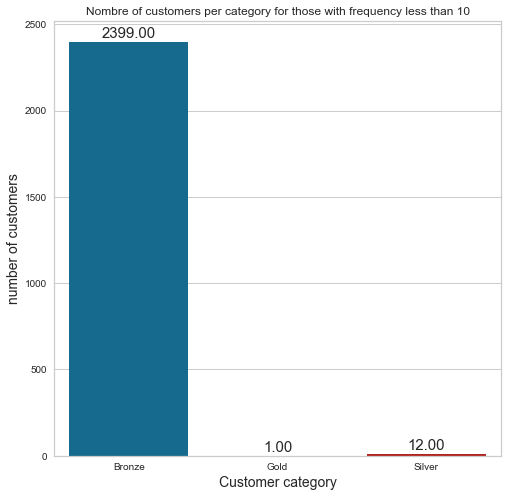

In [617]:
# Code source : https://www.geeksforgeeks.org/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/
# Defining the plot size
plt.figure(figsize=(8, 8))
 
# Defining the values for x-axis, y-axis
# and from which dataframe the values are to be picked
plots = sns.barplot(x="customer_category", y="n_customers", data=df_freq_2)
 
# Iterating over the bars one-by-one
for bar in plots.patches:
   
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),textcoords='offset points')

plt.xlabel("Customer category", size=14)
 
# Setting the label for y-axis
plt.ylabel("number of customers", size=14)

# Setting the title for the graph
plt.title("Nombre of customers per category for those with frequency less than 10")
 
# Finally showing the plot
plt.show()

In [582]:
df_rfmt[df_rfmt['frequency'] > 10].reset_index().groupby(['customer_category'])['CustomerID'].agg('count')

customer_category
Bronze     175
Diamond      4
Gold         6
Silver      33
Name: CustomerID, dtype: int64

__Analyzing the monetary values__

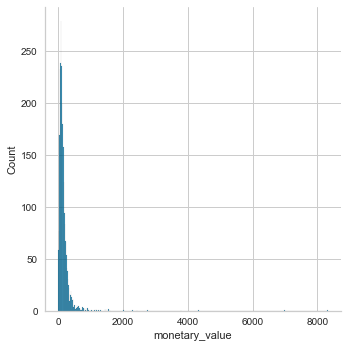

In [626]:
sns.displot(df_rfmt['monetary_value'])
plt.show()

In [633]:
df_rfmt['monetary_value'].describe()

count    2669.000000
mean      169.242452
std       291.921682
min         1.650000
25%        74.476667
50%       117.286667
75%       186.017500
max      8322.120000
Name: monetary_value, dtype: float64

In [634]:
df_mon = pd.DataFrame(df_rfmt.groupby(['customer_category'])['monetary_value'].mean().reset_index())

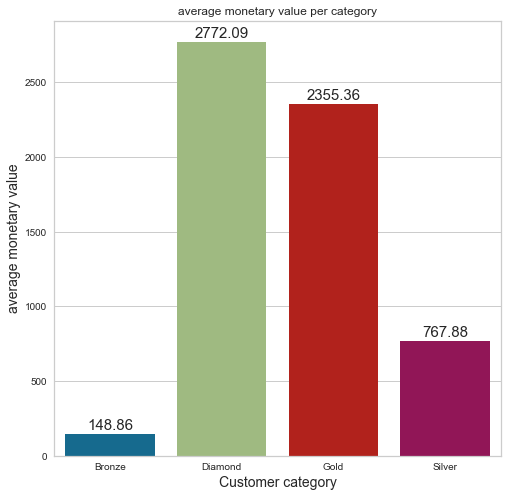

In [636]:
# Code source : https://www.geeksforgeeks.org/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/
# Defining the plot size
plt.figure(figsize=(8, 8))
 
# Defining the values for x-axis, y-axis
# and from which dataframe the values are to be picked
plots = sns.barplot(x="customer_category", y="monetary_value", data=df_mon)
 
# Iterating over the bars one-by-one
for bar in plots.patches:
   
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),textcoords='offset points')

plt.xlabel("Customer category", size=14)
 
# Setting the label for y-axis
plt.ylabel("average monetary value", size=14)
 
# Setting the title for the graph
plt.title("average monetary value per category")
 
# Finally showing the plot
plt.show()

In [650]:
# Getting the 80th percentile 
perct = df_rfmt['monetary_value'].quantile(q=0.8)

In [656]:
# Getting the number of customers per category for those with a monetary value greater than the 80th percentile.

df_mon_1 = pd.DataFrame(df_rfmt[df_rfmt['monetary_value'] > perct]\
                        .groupby(['customer_category'])['customer_category']\
                        .agg('count'))

df_mon_1.columns = ['n_customers']

df_mon_1 = df_mon_1.reset_index()



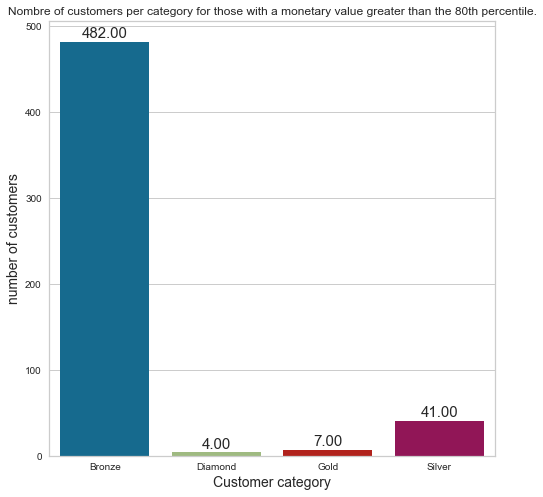

In [661]:
# Code source : https://www.geeksforgeeks.org/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/
# Defining the plot size
plt.figure(figsize=(8, 8))
 
# Defining the values for x-axis, y-axis
# and from which dataframe the values are to be picked
plots = sns.barplot(x="customer_category", y="n_customers", data=df_mon_1)
 
# Iterating over the bars one-by-one
for bar in plots.patches:
   
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),textcoords='offset points')

plt.xlabel("Customer category", size=14)
 
# Setting the label for y-axis
plt.ylabel("number of customers", size=14)
 
# Setting the title for the graph
plt.title("Nombre of customers per category for those with a monetary value greater than the 80th percentile.")
 
# Finally showing the plot
plt.show()


In [662]:
# Getting the number of customers per category for those with a monetary value less than the 80th percentile.

df_mon_2= pd.DataFrame(df_rfmt[df_rfmt['monetary_value'] < perct]\
                        .groupby(['customer_category'])['customer_category']\
                        .agg('count'))

df_mon_2.columns = ['n_customers']

df_mon_2 = df_mon_2.reset_index()


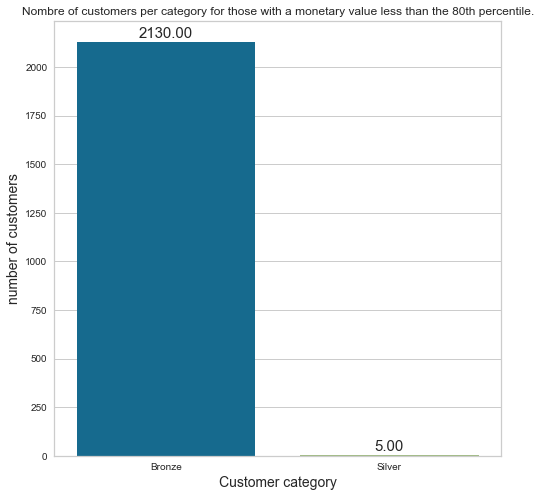

In [663]:
# Code source : https://www.geeksforgeeks.org/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/
# Defining the plot size
plt.figure(figsize=(8, 8))
 
# Defining the values for x-axis, y-axis
# and from which dataframe the values are to be picked
plots = sns.barplot(x="customer_category", y="n_customers", data=df_mon_2)
 
# Iterating over the bars one-by-one
for bar in plots.patches:
   
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),textcoords='offset points')

plt.xlabel("Customer category", size=14)
 
# Setting the label for y-axis
plt.ylabel("number of customers", size=14)
 
# Setting the title for the graph
plt.title("Nombre of customers per category for those with a monetary value less than the 80th percentile.")
 
# Finally showing the plot
plt.show()
